In [2]:
!pip install gym_sokoban

In [18]:
import argparse
import gym
import gym
import gym_sokoban
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torchvision

from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import math
import random 
import pandas as pd 
import seaborn as sns

In [3]:

image_transformations = T.Compose([
                    T.ToPILImage(),
                    T.Resize(64, interpolation= InterpolationMode.BILINEAR),
                    T.ToTensor(),
                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])





In [4]:
MAX_NUM_OF_ITERATIONS = 150
seed = 999

In [5]:
env = gym.make('PushAndPull-Sokoban-v2')

env.max_steps =  MAX_NUM_OF_ITERATIONS
screen = env.render(mode='rgb_array')
env.seed(seed)
torch.manual_seed(seed)
num_of_actions = env.action_space.n
num_of_actions

13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


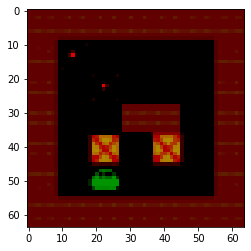

In [7]:
state_transformed = image_transformations(env.reset())
plt.imshow(state_transformed.permute(1,2,0).detach().cpu().numpy())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
ActionLog = namedtuple('ActionLog', ['log_prob', 'value'])

In [11]:
class Net(nn.Module):
    def __init__(self, num_of_actions):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.pre_actions1 = nn.Linear(400, 200)
        self.pre_actions2 = nn.Linear(200, 100)
        self.actions = nn.Linear(100, num_of_actions)

        self.pre_val1 = nn.Linear(400, 200)
        self.pre_val2 = nn.Linear(200, 100)
        self.val = nn.Linear(100, 1)

    def forward(self, x):

        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) 

        actions = F.leaky_relu(self.pre_actions1(x))
        actions = F.leaky_relu(self.pre_actions2(actions))
        actions = F.leaky_relu(self.actions(actions))
        actions = F.softmax(actions, dim=1)

        value = F.leaky_relu(self.pre_val1(x))
        value = F.leaky_relu(self.pre_val2(value))
        value = F.leaky_relu(self.val(value))
        
        
        return actions, value

    def init_weights(self):

      torch.nn.init.xavier_uniform_(self.conv1.weight)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions1.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions2.weight)

      torch.nn.init.xavier_uniform_(self.actions.weight)

      torch.nn.init.xavier_uniform_(self.pre_val1.weight)
      torch.nn.init.xavier_uniform_(self.pre_val2.weight)

      torch.nn.init.xavier_uniform_(self.val.weight)

  

      return self

class Agent:
    def __init__(self, net):
        self.net = net 

        self.saved_actions = []
        self.rewards = []

    def run_on_state(self, state):

        state = state.to(device)
        action_prob, value = self.net(state)
      
        return  action_prob, value


In [12]:
net = Net(num_of_actions).init_weights().to(device)

model = Agent(net)

optimizer = optim.RMSprop(net.parameters(), lr=0.001)

eps = np.finfo(np.float32).eps.item()

In [13]:
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.2
EPS_DECAY = 6000
steps_done = 0

In [14]:
def select_action(state):
  
    global steps_done
    steps_done += 1

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    state = image_transformations(state).unsqueeze(0)
    probs, state_value = model.run_on_state(state)
    m = Categorical(probs)

    if random.random() <= eps_threshold:
     
      action = random.randrange(num_of_actions)
      model.saved_actions.append(ActionLog(m.log_prob(torch.Tensor([action]).to(device)), state_value))
      return  action
    else:
      action = m.sample()
      model.saved_actions.append(ActionLog(m.log_prob(action), state_value))

      return action.item()

In [15]:
def train_on_episode():

    saved_actions = model.saved_actions
    policy_losses = [] 
    value_losses = [] 
    returns = []

    step_total_r = 0
    for step_immediate_rewars in reversed(model.rewards):
        step_total_r = step_immediate_rewars + GAMMA * step_total_r
        returns.insert(0, step_total_r)

    returns = torch.tensor(returns).to(device)

    for (log_prob, value), step_total_r in zip(saved_actions, returns):
        advantage = step_total_r - value.item()

        policy_losses.append(-log_prob * advantage)

        r_tensor = torch.tensor([step_total_r]).view(-1, 1).to(device)
        value_losses.append(F.smooth_l1_loss(value, r_tensor, beta = 1))

    optimizer.zero_grad()
  
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()
    
    model.rewards = []
    model.saved_actions = []

In [16]:
episodes_durations = []
steps_done = 0
net.train()

for episode_number in count(1):

  if episode_number % 50 == 0:
    print('episode_number {}'.format(episode_number))

  state = env.reset()

  for step_number in range(1, 10000):

    action = select_action(state)
    
    state, reward, done, _ = env.step(action)
            
    model.rewards.append(reward)

    if done:
      episodes_durations.append(step_number)
      break
  
  train_on_episode()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


episode_number 50
episode_number 100
episode_number 150
episode_number 200
episode_number 250
episode_number 300
episode_number 350
episode_number 400
episode_number 450


KeyboardInterrupt: ignored

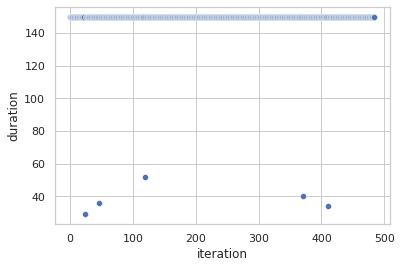

In [19]:


durations_df = pd.DataFrame([(iteration, duration) for (iteration, duration) in enumerate(episodes_durations)], columns =["iteration", "duration"])
sns.set_theme(style="whitegrid")

sns.scatterplot(data=durations_df, x="iteration", y="duration")